# 🤝 Federated Learning: Trening bez patrzenia na dane

W klasycznym ML wszystkie dane są na jednym serwerze.
W Federated Learning (FL) dane są rozproszone na tysiącach urządzeń (Klientów).

**Algorytm FedAvg (Federated Averaging):**
1.  **Global Server:** Inicjalizuje model globalny.
2.  **Broadcast:** Wysyła kopię modelu do wybranych klientów (np. 10 telefonów).
3.  **Local Update:** Każdy klient trenuje model na swoich prywatnych danych (np. przez 1 epokę).
4.  **Aggregation:** Klienci odsyłają nowe wagi. Serwer liczy średnią arytmetyczną wag.
5.  **Update:** Model globalny jest aktualizowany średnią. Powrót do kroku 2.

**Zaleta:** Serwer nigdy nie widzi zdjęcia Twojego kota, ale uczy się rozpoznawać koty.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import copy
import numpy as np

# Konfiguracja
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLIENTS = 5      # Symulujemy 5 szpitali/telefonów
ROUNDS = 5           # Ile razy serwer pobierze wagi?
LOCAL_EPOCHS = 1     # Ile każdy klient uczy się u siebie?

print(f"Symulacja FL na: {DEVICE}")

Symulacja FL na: cuda


## Symulacja Danych Rozproszonych

Podzielimy zbiór MNIST na 5 części. Każda część trafi do innego "Klienta".
W prawdziwym życiu te dane byłyby na fizycznie innych urządzeniach.

In [2]:
# Pobieramy MNIST
full_train_dataset = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST('data', train=False, transform=transforms.ToTensor())

# Dzielimy na 5 klientów
data_per_client = len(full_train_dataset) // NUM_CLIENTS
lengths = [data_per_client] * NUM_CLIENTS
client_datasets = random_split(full_train_dataset, lengths)

# Tworzymy DataLoadery dla każdego klienta
client_loaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in client_datasets]
test_loader = DataLoader(test_dataset, batch_size=1000)

print(f"Dane podzielone. Każdy z {NUM_CLIENTS} klientów ma {len(client_datasets[0])} prywatnych zdjęć.")

Dane podzielone. Każdy z 5 klientów ma 12000 prywatnych zdjęć.


## Model i Logika Lokalnego Treningu

Definiujemy prostą sieć.
Funkcja `train_local` symuluje to, co dzieje się na telefonie użytkownika. Pobiera model, trenuje go chwilę i zwraca **nowy stan wag** (`state_dict`).

In [3]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 20)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

def train_local(global_model, client_loader):
    """
    To dzieje się na urządzeniu klienta (Edge).
    """
    # Kopiujemy model globalny (żeby nie psuć oryginału w pamięci Pythona)
    local_model = copy.deepcopy(global_model)
    local_model.train()
    
    optimizer = optim.SGD(local_model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # Lokalny trening (np. 1 epoka)
    for epoch in range(LOCAL_EPOCHS):
        for data, target in client_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad()
            output = local_model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
    # Zwracamy WAGI (state_dict), a nie cały obiekt
    return local_model.state_dict()

# Inicjalizacja modelu globalnego (Serwer)
global_model = SimpleNet().to(DEVICE)
print("Model globalny zainicjowany.")

Model globalny zainicjowany.


## Algorytm FedAvg (Agregacja)

To jest serce serwera.
1.  Pobieramy słowniki wag od wszystkich klientów.
2.  Dla każdej wagi (np. `fc1.weight`) liczymy średnią:
    $$ W_{global} = \frac{1}{N} \sum_{i=1}^{N} W_{client\_i} $$
3.  Wgrywamy uśrednione wagi do modelu globalnego.

In [4]:
def federated_averaging(global_model, client_weights):
    """
    Serwer uśrednia wagi otrzymane od klientów.
    """
    # Pobieramy szablon wag z modelu globalnego
    global_dict = global_model.state_dict()
    
    # Dla każdego klucza (warstwy) w modelu...
    for key in global_dict.keys():
        # Pobieramy tę konkretną wagę od wszystkich klientów i robimy listę
        # client_weights to lista słowników
        all_weights_for_key = [client_w[key].float() for client_w in client_weights]
        
        # Liczymy średnią (stack -> mean)
        averaged_weight = torch.stack(all_weights_for_key).mean(dim=0)
        
        # Aktualizujemy słownik globalny
        global_dict[key] = averaged_weight
        
    # Wgrywamy nowe wagi do modelu globalnego
    global_model.load_state_dict(global_dict)
    return global_model

def evaluate(model):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    return 100. * correct / len(test_loader.dataset)

print("Funkcje serwera gotowe.")

Funkcje serwera gotowe.


Start FedAvg na 5 rund...
Accuracy na starcie (losowe wagi): 10.68%

--- RUNDA 1 ---
✅ Wszyscy klienci odesłali wagi.
📊 Global Accuracy po agregacji: 79.37%

--- RUNDA 2 ---
✅ Wszyscy klienci odesłali wagi.
📊 Global Accuracy po agregacji: 85.08%

--- RUNDA 3 ---
✅ Wszyscy klienci odesłali wagi.
📊 Global Accuracy po agregacji: 87.40%

--- RUNDA 4 ---
✅ Wszyscy klienci odesłali wagi.
📊 Global Accuracy po agregacji: 88.61%

--- RUNDA 5 ---
✅ Wszyscy klienci odesłali wagi.
📊 Global Accuracy po agregacji: 89.21%


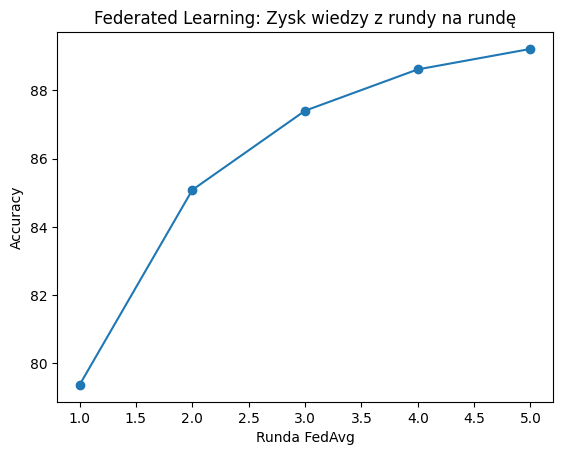

In [5]:
# GŁÓWNA PĘTLA SYMULACJI
print(f"Start FedAvg na {ROUNDS} rund...")
print(f"Accuracy na starcie (losowe wagi): {evaluate(global_model):.2f}%")

history = []

for round_idx in range(ROUNDS):
    print(f"\n--- RUNDA {round_idx + 1} ---")
    
    client_weights_list = []
    
    # 1. Wysyłamy model do klientów i czekamy na ich trening
    for i in range(NUM_CLIENTS):
        print(f"📡 Klient {i+1} trenuje...", end="\r")
        wagi_klienta = train_local(global_model, client_loaders[i])
        client_weights_list.append(wagi_klienta)
    
    print(f"✅ Wszyscy klienci odesłali wagi.")
    
    # 2. Agregacja na serwerze
    federated_averaging(global_model, client_weights_list)
    
    # 3. Test modelu globalnego
    acc = evaluate(global_model)
    history.append(acc)
    print(f"📊 Global Accuracy po agregacji: {acc:.2f}%")

# Wykres
import matplotlib.pyplot as plt
plt.plot(range(1, ROUNDS+1), history, marker='o')
plt.title("Federated Learning: Zysk wiedzy z rundy na rundę")
plt.xlabel("Runda FedAvg")
plt.ylabel("Accuracy")
plt.show()

## 🧠 Podsumowanie: Inteligencja roju

Zauważ, co się stało:
1.  Model globalny nigdy nie widział danych.
2.  Modele lokalne widziały tylko 1/5 danych.
3.  Mimo to, po wymianie wag, model globalny osiąga wysoką skuteczność (często >90%).

**Wyzwania w produkcji:**
*   **Non-IID Data:** Co jeśli jeden klient ma same zdjęcia kotów, a drugi same zdjęcia psów? Średnia z ich wag może wyjść bez sensu. (Wymaga zaawansowanych technik np. FedProx).
*   **Komunikacja:** Przesyłanie wag modelu (np. 100MB) z miliona telefonów zatyka sieć. (Stosuje się kompresję i LoRA).